# Evaluación de la segmentación

In [1]:
import cv2 as cv # ver. 4.5.5
import numpy as np
from matplotlib import pyplot as plt

## Imágenes a utilizar

En esta ocasión se usarán cartas de póquer para establecer la segmentación de objetos. Las imágenes `img_07c`, `img_09d`, `img_10c` y `img_10t` contienen una sola carta, en este caso se pretenderá identificar cuantos elementos la constituyen: números y figuras. Por su porte, las imágenes `img_all` y `img_4a6` contienen varias cartas, por lo que se pretenderá identificar cuántas cartas hay en la imagen.

In [2]:
img_07c = cv.imread('im/07c.jpg')
img_09d = cv.imread('im/09d.png')
img_10c = cv.imread('im/10c.jpg')
img_10t = cv.imread('im/10t.jpg')
img_all = cv.imread('im/all.png')
img_4a6 = cv.imread('im/4a6.jpg')

## Segmentación con Canny

Primero seleccionaremos una de las seis imágenes de trabajo

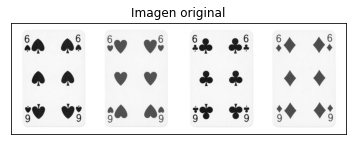

In [3]:
im = img_4a6
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

Una vez que seleccionamos una imagen en escala de grises, es posible obtener una imagen binaria con los bordes claramente identificados gracias al algoritmo de Canny.

In [4]:
# Los números son las intensidades min y máx para identificar el borde
canny = cv.Canny(im, 25, 100)
cv.imwrite('out/canny.jpg', canny)

True

Ahora procederemos a la segmentación de la imagen. El método `cv.findContours()` encuentra los contornos en una imagen binaria (primer parámetro). Debe especificarse el algoritmo que usará para encontrar los contornos (segundo parámetro):

- `RETR_EXTERNAL`: Detecta solo los bordes más externos.
- `RETR_LIST`: Detecta todos los contornos.
- `RETR_CCOMP` y `RETR_TREE`: Detectan todos los bordes y establecen alguna jerarquía entre ellos.

El último parámetro establece el método de aproximación para el contorno, los principales son:

- `CHAIN_APPROX_NONE`: Almacena absolutamente todos los puntos de contorno.
- `CHAIN_APPROX_SIMPLE`: Comprime segmentos horizontales, verticales y diagonales y deja sólo sus puntos finales.

Al cambiar este último parámetro no se han observado cambios en el resultado.

Por su parte el método `drawContours()` dibujará los contornos sobre la imagen original (primer parámetro); para ello debe acceder a los contornos previamente obtenidos (segundo parámetro). El tercer parámetro es aquel contorno específico a dibujar, `-1` significa todos. Los parámetros siguientes serán el color del contorno y su grosor.

In [5]:
contours, hierarchy = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
out = cv.drawContours(im, contours, -1, (64,255,64), 1)
cv.imwrite('out/out.jpg', out)
print('Número de contornos encontrados: ', len(contours))

Número de contornos encontrados:  4


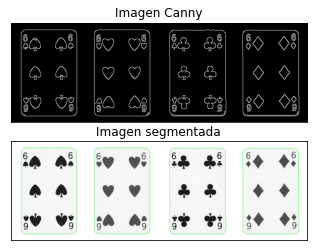

In [6]:
canny = cv.cvtColor(canny, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(211)
plt.imshow(canny)
plt.title('Imagen Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(212)
plt.imshow(out)
plt.title('Imagen segmentada'), plt.xticks([]), plt.yticks([])
plt.show()

Como puede observarse en la imagen, los contornos son dibujados propiamente, sin embargo, el número de contornos puede no coincidir con el número de objetos en la imagen. Por ejemplo, los tréboles debido a lo angosto de la parte media del dibujo, pueden ser identificados como dos objetos y no como uno. A continuación se presenta una lista con la relación de objetos y contornos detectados:

<a id="tbl:1"></a>

| Imagen| Objetos observables | Segmentos detectados
| :--- | :--- | :---
| img_07c | 11 | 11
| img_09d | 13 | 14
| img_10c | 16 | 16
| img_10t | 16 | 18
| img_all | 52 | 56
| img_4a6 | 4 | 4

Es bien sabido que el algoritmo de Canny aplica una reducción de ruido con un filtro gausiano como primer paso. Parece ser que no es suficiente en todos los casos.

## Segmentación con umbralado

Es posible usar un umbralado directo para generar una imagen en binario. En este caso usaremos solo las imágenes que presentaron fallas en la sección anterior: `img_09d`, `img_10t` y `img_all`.

Este método mejora el resultado siempre y cuando la variable `thresh` tenga el valor ideal. Aquí se coloca el ejemplo que funciona con la imagen `img_09d` donde `thresh = 32`, para corregir la imagen `img_all` es necesario establecer `thresh = 160`.

Se hizo la prueba cambiando el algoritmo de umbralado a `THRESH_OTSU`, pero no se observó ninguna mejora.

In [7]:
im = img_09d
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
# Imagen en binario
thresh = 32 #Los bits del umbralado
binary = cv.threshold(im, thresh, 255, cv.THRESH_BINARY)[1]

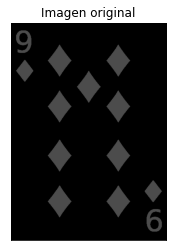

In [8]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

In [9]:
contours, hierarchy = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
out = cv.drawContours(im, contours, -1, (64,255,64), 3)
cv.imwrite('out/bin.jpg', binary)
cv.imwrite('out/bin_out.jpg', out)
print('Número de contornos encontrados: ', len(contours))

Número de contornos encontrados:  13


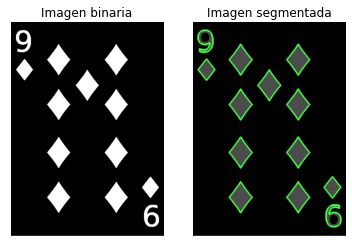

In [10]:
binary = cv.cvtColor(binary, cv.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(binary)
plt.title('Imagen binaria'), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title('Imagen segmentada'), plt.xticks([]), plt.yticks([])
plt.show()

Es posible observar los siguientes resultados mediante este método:

| Carta | Objetos observables | Segmentos detectados (Umbral)
| :--- | :--- | :--- 
| img_09d | 13 | 13 (32)
| img_10t | 16 | 1
| img_all | 52 | 52 (160)

Así com sucede en el caso de la imagen `img_10t`, es posible que este método encuentre como contorno más externo los límites de la imagen, esto es posible solucionando si el algoritmo del método `cv.findContours()` cambia a `RETR_LIST`. Esto mejorará el comportamiento porque será posible identificar los contornos internos, no solo los externos. Pese a esto, en la mayoría de los casos eleva demasiado el número de bordes encontrados en la imagen.

## Segmentación con color

Otra forma de identificar los segmentos es usando el color en el proceso. La ventaja de este método es que permitirá identificar objetos que se encuentren en un rango de color.

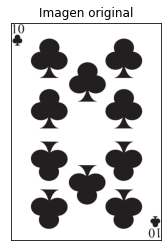

In [11]:
im = img_10t
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
plt.imshow(im)
plt.title("Imagen original"), plt.xticks([]), plt.yticks([])
plt.show()

Es necesario especificar el rango de color de interés. En el siguiente código se comentan los valores que encontrarían en una carta roja y se aplican aquellos que tienen que ver con el negro, propio de la imagen seleccionada.

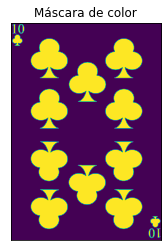

In [12]:
#light_red = (205, 0, 0)
#dark_red = (255, 200, 200)
#mask = cv.inRange(im, light_red, dark_red)
light_black = (205, 205, 205)
dark_black = (0, 0, 0)
mask = cv.inRange(im, dark_black, light_black)
cv.imwrite('out/color_mask.jpg', mask)
plt.imshow(mask)
plt.title("Máscara de color"), plt.xticks([]), plt.yticks([])
plt.show()

In [13]:
contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
out = cv.drawContours(im, contours, -1, (64,255,64), 3)
cv.imwrite('out/color_out.jpg', out)
print('Número de contornos encontrados: ', len(contours))

Número de contornos encontrados:  16


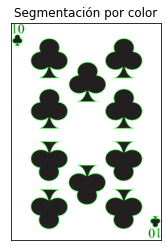

In [14]:
plt.imshow(out)
plt.title("Segmentación por color"), plt.xticks([]), plt.yticks([])
plt.show()

En esta ocasión fue posible obtener el resultado deseado para la última imagen pendiente: `img_10t`. Además este método es preciso con otras imágenes similares. En caso seleccionar una imagen con varias cartas, este método encontraría todos los elementos del color de interés, mas no contaría el número de cartas que aparecen en la imagen.

## Conclusión

La segmentación de una imagen es un trabajo de presición. Es necesario elegir el curso de acción adecuado para cada situación, debido a que hasta donde puede verse, no existe una forma que presente un resultado satisfactorio para todos los casos, incluso si la dificultad que presentan las imágenes es relativamente sencilla.

Para el presente caso, la segmentación con color parece ser un procedimiento fácilmente adaptable para imágenes que no exceden los dos colores, sin embargo podría traer problemas si la imagen a procesar tiene mayor número de colores.

***
Ver [Este enlace](https://circuitdigest.com/tutorial/image-segmentation-using-opencv) sobre segmentación y la documentación oficial de la [version 4.5.5 de opencv](https://docs.opencv.org/4.5.5/d4/d73/tutorial_py_contours_begin.html).

[Ver código](https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/#2_Image_Segmentation_using_Contour_Detection)
***

Por favor ver [Tabla 1](#tbl:1) y [Imágenes a utilizar](#Imágenes-a-utilizar)


\begin{align}
    g &= \int_a^b f(x)dx \label{eq1}\tag{1} \\
    a &= b + c \label{eq2}\tag{2}
\end{align}

See (\ref{eq1}) and (\ref{eq2})

See (\ref{eq1}) and (\ref{eq2}) does not work from another cell.
See ([1](#mjx-eqn-eq1)) and ([2](#mjx-eqn-eq2)) does work from another cell.